In [4]:
import os
import gymnasium as gym
import flappy_bird_gymnasium as flappy_bird
import torch
import numpy as np
import matplotlib.pyplot as plt

from collections import deque, defaultdict
from gymnasium.wrappers import RecordVideo

import sys
sys.path.append(os.path.abspath("../"))

from model import DQN_CNN
from save_model.utils import transition
import tqdm


plt.rcParams["figure.figsize"] = (10, 5)


/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [5]:
MODEL_PATH = "../best_dqn.pt"
ENV_NAME = "FlappyBird-v0"
DEVICE = "cpu"

NUM_EPISODES = 300
FRAME_SKIP = 4
MAX_STEPS = 10_000  # safety cap


In [6]:
state_dict = torch.load("../best_dqn.pt", map_location=DEVICE)
for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([8, 4, 3, 3])
conv1.bias torch.Size([8])
conv2.weight torch.Size([16, 8, 3, 3])
conv2.bias torch.Size([16])
conv3.weight torch.Size([32, 16, 3, 3])
conv3.bias torch.Size([32])
fc1.weight torch.Size([256, 3200])
fc1.bias torch.Size([256])
fc2.weight torch.Size([128, 256])
fc2.bias torch.Size([128])
fc3.weight torch.Size([2, 128])
fc3.bias torch.Size([2])
net.0.weight torch.Size([8, 4, 3, 3])
net.0.bias torch.Size([8])
net.3.weight torch.Size([16, 8, 3, 3])
net.3.bias torch.Size([16])
net.6.weight torch.Size([32, 16, 3, 3])
net.6.bias torch.Size([32])
net.10.weight torch.Size([256, 3200])
net.10.bias torch.Size([256])
net.11.weight torch.Size([256])
net.11.bias torch.Size([256])
net.13.weight torch.Size([128, 256])
net.13.bias torch.Size([128])
net.14.weight torch.Size([128])
net.14.bias torch.Size([128])
net.16.weight torch.Size([2, 128])
net.16.bias torch.Size([2])


In [7]:
policy_net = DQN_CNN(FRAME_SKIP).to(DEVICE)
for k, v in policy_net.state_dict().items():
    print(k, v.shape)


state_dict = torch.load("../best_dqn.pt", map_location=DEVICE)
policy_net.load_state_dict(state_dict)

policy_net.eval()
print("✅ Model loaded")



conv1.weight torch.Size([8, 4, 3, 3])
conv1.bias torch.Size([8])
conv2.weight torch.Size([16, 8, 3, 3])
conv2.bias torch.Size([16])
conv3.weight torch.Size([32, 16, 3, 3])
conv3.bias torch.Size([32])
fc1.weight torch.Size([256, 3200])
fc1.bias torch.Size([256])
fc2.weight torch.Size([128, 256])
fc2.bias torch.Size([128])
fc3.weight torch.Size([2, 128])
fc3.bias torch.Size([2])
net.0.weight torch.Size([8, 4, 3, 3])
net.0.bias torch.Size([8])
net.3.weight torch.Size([16, 8, 3, 3])
net.3.bias torch.Size([16])
net.6.weight torch.Size([32, 16, 3, 3])
net.6.bias torch.Size([32])
net.10.weight torch.Size([256, 3200])
net.10.bias torch.Size([256])
net.11.weight torch.Size([256])
net.11.bias torch.Size([256])
net.13.weight torch.Size([128, 256])
net.13.bias torch.Size([128])
net.14.weight torch.Size([128])
net.14.bias torch.Size([128])
net.16.weight torch.Size([2, 128])
net.16.bias torch.Size([2])
✅ Model loaded


In [8]:
def run_single_episode(env, model, frame_skip, device):
    frame_stack = deque(maxlen=frame_skip)

    state, _ = env.reset()
    done = False
    steps = 0

    total_reward = 0.0
    alive_frames = 0
    pipes_passed = 0
    deaths = 0
    top_hits = 0

    current_state, _, _ = transition(0, env, frame_skip)

    while not done and steps < MAX_STEPS:
        with torch.no_grad():
            state_t = torch.tensor(
                current_state, dtype=torch.float32
            ).unsqueeze(0).to(device)
            action = model(state_t).argmax(dim=1).item()

        next_state, reward_sum, done = transition(action, env, frame_skip)
        current_state = next_state

        total_reward += reward_sum
        steps += 1

        # ---------- reward decomposition ----------
        if reward_sum > 0:
            alive_frames += reward_sum / 0.1
            if reward_sum >= 1.0:
                pipes_passed += int(reward_sum // 1.0)

        if reward_sum <= -1.0:
            deaths += 1
        if reward_sum <= -0.5:
            top_hits += 1

    return {
        "total_reward": total_reward,
        "steps": steps,
        "alive_frames": alive_frames,
        "pipes_passed": pipes_passed,
        "deaths": deaths,
        "top_hits": top_hits,
    }


In [ ]:
env = gym.make(ENV_NAME, render_mode="rgb_array")


metrics = defaultdict(list)

for episode in tqdm.tqdm(range(NUM_EPISODES)):
    episode_metrics = run_single_episode(
        env, policy_net, FRAME_SKIP, DEVICE
    )

    for k, v in episode_metrics.items():
        metrics[k].append(v)

    print(
        f"Episode {episode+1:03d} | "
        f"Reward: {episode_metrics['total_reward']:.2f} | "
        f"Pipes: {episode_metrics['pipes_passed']}"
    )

env.close()


  0%|          | 0/300 [00:00<?, ?it/s]/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/stefaniancu/Documents/Q-learning-CNN-in-Flappy-Bird-Environment/.venv/lib/python3.13/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
  0%|          | 1/300 [00:06<33:27,  6.72s/it]

Episode 001 | Reward: 45.30 | Pipes: 16


  1%|          | 2/300 [00:51<2:23:38, 28.92s/it]

Episode 002 | Reward: 287.50 | Pipes: 99


  1%|          | 3/300 [00:58<1:33:57, 18.98s/it]

Episode 003 | Reward: 54.80 | Pipes: 12


  1%|▏         | 4/300 [00:59<59:38, 12.09s/it]  

Episode 004 | Reward: 15.20 | Pipes: 1


  2%|▏         | 5/300 [01:03<44:45,  9.10s/it]

Episode 005 | Reward: 12.40 | Pipes: 8


  2%|▏         | 6/300 [01:11<43:10,  8.81s/it]

Episode 006 | Reward: 52.90 | Pipes: 12


  2%|▏         | 7/300 [01:20<43:09,  8.84s/it]

Episode 007 | Reward: 60.10 | Pipes: 20


  3%|▎         | 8/300 [01:35<52:34, 10.80s/it]

Episode 008 | Reward: 105.30 | Pipes: 34


  3%|▎         | 9/300 [01:47<53:06, 10.95s/it]

Episode 009 | Reward: 70.60 | Pipes: 25


  3%|▎         | 10/300 [02:01<57:32, 11.91s/it]

Episode 010 | Reward: 98.70 | Pipes: 24


  4%|▎         | 11/300 [02:02<42:15,  8.77s/it]

Episode 011 | Reward: 14.80 | Pipes: 2


  4%|▍         | 12/300 [02:25<1:02:46, 13.08s/it]

Episode 012 | Reward: 162.70 | Pipes: 49


  4%|▍         | 13/300 [02:33<54:20, 11.36s/it]  

Episode 013 | Reward: 47.60 | Pipes: 19


  5%|▍         | 14/300 [02:36<42:27,  8.91s/it]

Episode 014 | Reward: 32.30 | Pipes: 4


  5%|▌         | 15/300 [02:48<46:15,  9.74s/it]

Episode 015 | Reward: 83.00 | Pipes: 27


  5%|▌         | 16/300 [02:53<40:36,  8.58s/it]

Episode 016 | Reward: 40.70 | Pipes: 13


  6%|▌         | 17/300 [03:07<47:09, 10.00s/it]

Episode 017 | Reward: 80.30 | Pipes: 28


  6%|▌         | 18/300 [03:14<42:56,  9.14s/it]

Episode 018 | Reward: 54.80 | Pipes: 12


  6%|▋         | 19/300 [03:17<34:35,  7.38s/it]

Episode 019 | Reward: 25.00 | Pipes: 5


  7%|▋         | 20/300 [03:21<29:43,  6.37s/it]

Episode 020 | Reward: 25.50 | Pipes: 8


  7%|▋         | 21/300 [03:26<28:05,  6.04s/it]

Episode 021 | Reward: 33.00 | Pipes: 12


  7%|▋         | 22/300 [03:36<33:33,  7.24s/it]

Episode 022 | Reward: 55.90 | Pipes: 19


  8%|▊         | 23/300 [03:41<28:59,  6.28s/it]

Episode 023 | Reward: 31.40 | Pipes: 10


  8%|▊         | 24/300 [04:12<1:03:11, 13.74s/it]

Episode 024 | Reward: 220.30 | Pipes: 56


  8%|▊         | 25/300 [04:22<58:35, 12.78s/it]  

Episode 025 | Reward: 62.20 | Pipes: 23


  9%|▊         | 26/300 [04:28<48:56, 10.72s/it]

Episode 026 | Reward: 47.50 | Pipes: 11


  9%|▉         | 27/300 [04:30<37:04,  8.15s/it]

Episode 027 | Reward: 16.30 | Pipes: 5


  9%|▉         | 28/300 [04:40<39:42,  8.76s/it]

Episode 028 | Reward: 76.90 | Pipes: 20


 10%|▉         | 29/300 [04:45<33:55,  7.51s/it]

Episode 029 | Reward: 41.20 | Pipes: 11


 10%|█         | 30/300 [04:52<32:39,  7.26s/it]

Episode 030 | Reward: 49.30 | Pipes: 9


 10%|█         | 31/300 [05:16<55:28, 12.37s/it]

Episode 031 | Reward: 182.30 | Pipes: 57


 11%|█         | 32/300 [05:26<52:39, 11.79s/it]

Episode 032 | Reward: 87.40 | Pipes: 14


 11%|█         | 33/300 [05:31<42:57,  9.65s/it]

Episode 033 | Reward: 43.60 | Pipes: 7


 11%|█▏        | 34/300 [05:39<40:14,  9.08s/it]

Episode 034 | Reward: 61.30 | Pipes: 22


 12%|█▏        | 35/300 [05:46<37:09,  8.41s/it]

Episode 035 | Reward: 47.30 | Pipes: 13


 12%|█▏        | 36/300 [05:48<28:53,  6.57s/it]

Episode 036 | Reward: 14.00 | Pipes: 3


 12%|█▏        | 37/300 [06:00<35:21,  8.07s/it]

Episode 037 | Reward: 83.00 | Pipes: 30


 13%|█▎        | 38/300 [06:03<29:15,  6.70s/it]

Episode 038 | Reward: 28.10 | Pipes: 8


 13%|█▎        | 39/300 [06:22<45:36, 10.48s/it]

Episode 039 | Reward: 149.50 | Pipes: 45


 13%|█▎        | 40/300 [06:26<36:44,  8.48s/it]

Episode 040 | Reward: 20.80 | Pipes: 3


 14%|█▎        | 41/300 [06:34<35:52,  8.31s/it]

Episode 041 | Reward: 63.00 | Pipes: 17


 14%|█▍        | 42/300 [06:40<32:01,  7.45s/it]

Episode 042 | Reward: 44.20 | Pipes: 16


 14%|█▍        | 43/300 [06:45<29:43,  6.94s/it]

Episode 043 | Reward: 38.80 | Pipes: 13


 15%|█▍        | 44/300 [06:47<23:14,  5.45s/it]

Episode 044 | Reward: 19.50 | Pipes: 2


 15%|█▌        | 45/300 [06:54<25:17,  5.95s/it]

Episode 045 | Reward: 58.60 | Pipes: 14


 15%|█▌        | 46/300 [06:57<20:28,  4.84s/it]

Episode 046 | Reward: 8.40 | Pipes: 4


 16%|█▌        | 47/300 [06:58<15:34,  3.69s/it]

Episode 047 | Reward: 4.50 | Pipes: 2


 16%|█▌        | 48/300 [06:59<12:34,  3.00s/it]

Episode 048 | Reward: 8.80 | Pipes: 2


 16%|█▋        | 49/300 [07:21<36:56,  8.83s/it]

Episode 049 | Reward: 140.10 | Pipes: 47


 17%|█▋        | 50/300 [07:25<29:49,  7.16s/it]

Episode 050 | Reward: 23.90 | Pipes: 5


 17%|█▋        | 51/300 [07:52<54:57, 13.24s/it]

Episode 051 | Reward: 191.00 | Pipes: 59


 17%|█▋        | 52/300 [07:55<42:03, 10.18s/it]

Episode 052 | Reward: 15.90 | Pipes: 6


 18%|█▊        | 53/300 [08:22<1:02:10, 15.10s/it]

Episode 053 | Reward: 193.10 | Pipes: 52


 18%|█▊        | 54/300 [08:27<49:42, 12.13s/it]  

Episode 054 | Reward: 43.00 | Pipes: 10


 18%|█▊        | 55/300 [08:29<37:31,  9.19s/it]

Episode 055 | Reward: 19.10 | Pipes: 6


 19%|█▊        | 56/300 [08:35<33:15,  8.18s/it]

Episode 056 | Reward: 38.20 | Pipes: 11


 19%|█▉        | 57/300 [08:55<47:45, 11.79s/it]

Episode 057 | Reward: 109.70 | Pipes: 41


 19%|█▉        | 58/300 [09:02<41:07, 10.20s/it]

Episode 058 | Reward: 45.60 | Pipes: 10


 20%|█▉        | 59/300 [09:17<47:01, 11.71s/it]

Episode 059 | Reward: 78.40 | Pipes: 30


In [ ]:
def summarize(values):
    return {
        "mean": np.mean(values),
        "std": np.std(values),
        "min": np.min(values),
        "max": np.max(values),
    }

summary = {
    key: summarize(val)
    for key, val in metrics.items()
}



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def plot_reward_distribution_with_density(
    metrics,
    bins=100,
    smoothing_sigma=2.0,
    title="Total Reward Distribution",
    xlabel="Total Reward",
    ylabel="Density",
    show=True,
    ax=None,
):
    """
    Plot a histogram of total rewards with a smooth density curve
    that follows the shape of the bins.

    Args:
        metrics (dict): Dictionary containing 'total_reward'.
        bins (int): Number of histogram bins.
        smoothing_sigma (float): Gaussian smoothing strength for the curve.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label.
        show (bool): Whether to call plt.show().
        ax (matplotlib.axes.Axes, optional): Existing axes.

    Returns:
        matplotlib.axes.Axes
    """
    rewards = np.asarray(metrics["total_reward"])

    if ax is None:
        fig, ax = plt.subplots()

    # Histogram (normalized)
    counts, bin_edges, _ = ax.hist(
        rewards,
        bins=bins,
        density=True,
        alpha=0.6,
        label="Histogram"
    )

    # Bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Smooth the histogram counts
    smooth_counts = gaussian_filter1d(counts, sigma=smoothing_sigma)

    # Plot smooth curve
    ax.plot(
        bin_centers,
        smooth_counts,
        linewidth=2,
        label="Smoothed Density"
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

    if show:
        plt.show()

    return ax


plot_reward_distribution_with_density(
    metrics,
    bins=100,
    smoothing_sigma=2.5,
    title="Total Reward Distribution (100 Episodes)"
)



NameError: name 'plt' is not defined

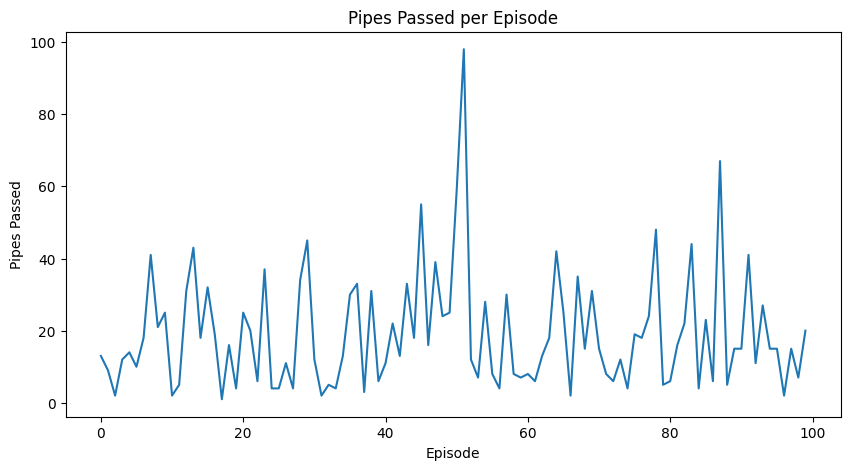

In [ ]:
pipes = metrics["pipes_passed"]
mean_pipes = np.mean(pipes)

plt.plot(pipes, label="Pipes Passed per Episode")
plt.axhline(
    y=mean_pipes,
    linestyle="--",
    linewidth=2,
    label=f"Mean = {mean_pipes:.2f}"
)

plt.title("Pipes Passed per Episode")
plt.xlabel("Episode")
plt.ylabel("Pipes Passed")
plt.legend()
plt.show()


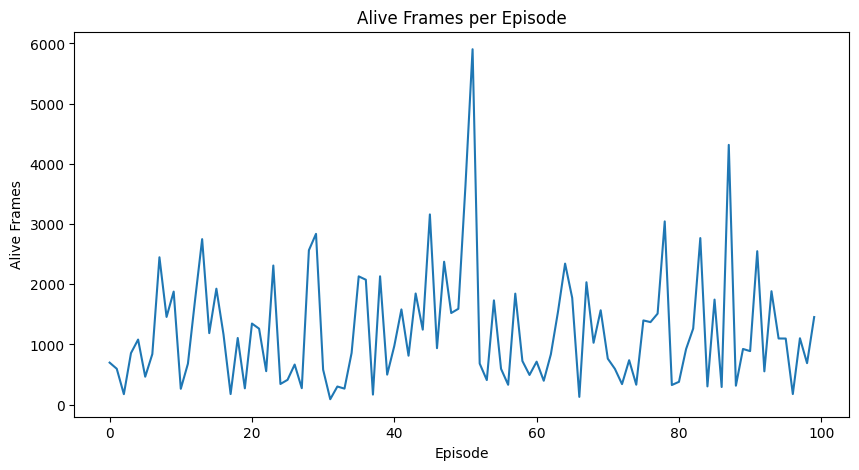

In [ ]:
plt.plot(metrics["alive_frames"])
plt.title("Alive Frames per Episode")
plt.xlabel("Episode")
plt.ylabel("Alive Frames")
plt.show()


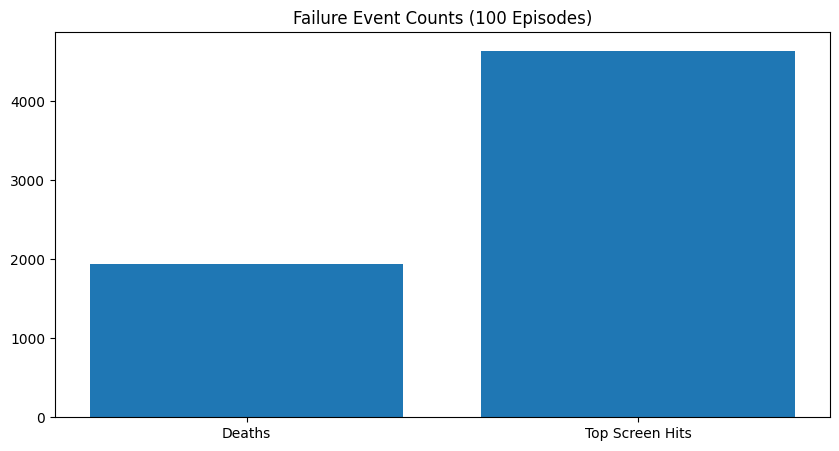

In [ ]:
labels = ["Deaths", "Top Screen Hits"]
values = [
    sum(metrics["deaths"]),
    sum(metrics["top_hits"]),
]

plt.bar(labels, values)
plt.title("Failure Event Counts (100 Episodes)")
plt.show()


In [ ]:
import json
import pandas as pd
from pathlib import Path

OUTPUT_DIR = Path("metrics")
OUTPUT_DIR.mkdir(exist_ok=True)


ModuleNotFoundError: No module named 'pandas'

In [ ]:
df = pd.DataFrame(metrics)
df.index.name = "episode"

csv_path = OUTPUT_DIR / "episodes.csv"
df.to_csv(csv_path)

print(f"✅ Episode metrics saved to {csv_path}")
